In [1]:
pip install mirdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=9496912144abc58dba08774aec9a997359afffece9a616bdf0d58c596c996e57
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64923 sha256=6d432afb7a919eddab1d60fdca0

In [2]:
import pandas
import os 
import pickle

import time

import mirdata
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling1D

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# GLOBAL PATHS and variables
pickleFiles_FolderName = '/content/gdrive/MyDrive/Colab Notebooks/Music Information Retrieval/Assignment/Final'

In [4]:
tensF_ShuffleSeed = 0
train_split = 0.8 # validation split is the same as train_split

In [5]:
# https://mirdata.readthedocs.io/en/stable/source/mirdata.html#module-mirdata.datasets.freesound_one_shot_percussive_sounds

percDataset = mirdata.initialize("freesound_one_shot_percussive_sounds")
percDataset.download()  
print('Finished downloading freesound_one_shot_percussive_sounds dataset.')
percDataset.validate() 
print('Finished validating freesound_one_shot_percussive_sounds dataset.')

107MB [00:24, 4.57MB/s]                           
5.35MB [00:01, 5.17MB/s]                            
57.3MB [00:01, 49.8MB/s]                            
1.29MB [00:00, 1.72MB/s]                           
8.00kB [00:00, 12.4kB/s]


Finished downloading freesound_one_shot_percussive_sounds dataset.


100%|██████████| 10254/10254 [00:01<00:00, 5789.10it/s]

Finished validating freesound_one_shot_percussive_sounds dataset.


In [6]:
# Find min and max values of timbral synthesis features annotations, 
# so that we can normalize later
with open(os.path.join(pickleFiles_FolderName, 'audioFileWavef_TimbralFeatures_DF.p'), 'rb') as audioFileWavef_TimbralFeatures_DF_Pickle:
  audioFileWavef_TimbralFeatures_DF = pickle.load(audioFileWavef_TimbralFeatures_DF_Pickle)

audioFileWavef_TimbralFeatures_DF.head() # successfully retrieved pandas dataframe from pickle file

,freesound_sound_id,audio_waveform_sampleN_0,audio_waveform_sampleN_1,audio_waveform_sampleN_2,audio_waveform_sampleN_3,audio_waveform_sampleN_4,audio_waveform_sampleN_5,audio_waveform_sampleN_6,audio_waveform_sampleN_7,audio_waveform_sampleN_8,...,audio_waveform_sampleN_15997,audio_waveform_sampleN_15998,audio_waveform_sampleN_15999,hardness,depth,brightness,roughness,warmth,sharpness,boominess
0,203887,-0.000031,-0.000031,0.000000,-0.000031,-0.000031,-0.000031,0.000000,0.000031,0.000031,...,0.0,0.0,0.0,58.964800,52.583343,51.286288,54.450442,53.450765,43.850985,36.458663
1,203893,-0.000031,-0.000031,-0.000031,-0.000031,0.000000,0.000000,0.000000,0.000031,0.000061,...,0.0,0.0,0.0,68.950243,35.996983,71.406639,67.818761,34.422775,58.811990,21.432983
2,319613,0.023254,-0.362274,-0.115540,0.606995,0.025940,-0.159943,0.004211,-0.385834,0.056091,...,0.0,0.0,0.0,70.543572,54.408973,62.367384,55.920217,39.524543,53.265036,37.984857
3,361958,-0.003174,-0.002441,-0.009338,-0.005646,-0.014252,-0.008392,-0.015869,0.002869,0.007721,...,0.0,0.0,0.0,54.433781,70.611045,38.445561,43.515676,55.998536,40.757533,43.517493
4,277684,0.001007,0.001984,0.002197,0.002533,0.002716,0.002594,0.002838,0.003174,0.002899,...,0.0,0.0,0.0,71.738502,57.402842,73.531486,50.322603,36.656637,56.843763,28.371194


In [7]:
timbFeat_List = ["hardness", "depth", "brightness", "roughness", "warmth", "sharpness", "boominess"]

In [8]:
timbFeat_MinList = audioFileWavef_TimbralFeatures_DF[timbFeat_List].min(axis = 0, numeric_only = True)
timbFeat_MaxList = audioFileWavef_TimbralFeatures_DF[timbFeat_List].max(axis = 0, numeric_only = True)

In [9]:
print(timbFeat_MinList)
print(timbFeat_MaxList)

hardness      11.586026
depth          0.140980
brightness    10.874446
roughness      0.000000
warmth         7.696248
sharpness      0.000000
boominess      0.000000
dtype: float64
hardness       82.596457
depth         100.000000
brightness     84.309024
roughness      77.090665
warmth         78.870422
sharpness      92.585410
boominess      71.482249
dtype: float64


In [10]:
timbFeat_List = ["ac_hardness", "ac_depth", "ac_brightness", "ac_roughness", "ac_warmth", "ac_sharpness", "ac_boominess"]

In [11]:
# https://mirdata.readthedocs.io/en/stable/source/tutorial.html

def freeSound_PercDataset_generator():
    track_ids = percDataset.track_ids
    for track_id in track_ids:
      track = percDataset.track(track_id)
      audio_signal, _ = track.audio
      audioSignal = np.array(audio_signal)
      audioSignal.resize(16000, refcheck=False)
      # print(len(audioSignal))
      # consider training example as valid only if all annotations are present
      # (there are some missing keys in the mir_data track.audiocommons_analysis dict)
      timbFeaturesGroundTruth = []
      for index, timbFeatName in enumerate(timbFeat_List):
        # apply normalization between 0 and 1 (y = x-min(x) / max(x) - min(x))
        if timbFeatName in track.audiocommons_analysis.keys():
          normValue = (track.audiocommons_analysis[timbFeatName] - timbFeat_MinList[index]) / (timbFeat_MaxList[index] - timbFeat_MinList[index])
          timbFeaturesGroundTruth.append(np.float32(normValue))
        else:
          timbFeaturesGroundTruth.append(0.)
      # Keras' Input layer accepts either 2 different 'datasets' for x (examples) and y (ground truth),
      # or a single tuple object as (x, y)
      # https://keras.io/api/models/model_training_apis/ 
      yield (audioSignal,
              timbFeaturesGroundTruth)

dataset = tf.data.Dataset.from_generator(
    freeSound_PercDataset_generator,
    output_signature=(
         tf.TensorSpec(shape = (16000), dtype = tf.float32, name = 'audio_waveform'),
         tf.TensorSpec(shape = (7), dtype = tf.float32, name = 'annotations')))

In [12]:
dataset

<FlatMapDataset element_spec=(TensorSpec(shape=(16000,), dtype=tf.float32, name='audio_waveform'), TensorSpec(shape=(7,), dtype=tf.float32, name='annotations'))>

In [13]:
# check dataset 
#for element in dataset:
#  print(element)

In [14]:
# Shuffle entire dataset and split it into train/validation/test datasets

num_elements = len(list(dataset))
print(f'There are {num_elements} elements in the Dataset')

dataset = dataset.shuffle(num_elements, seed=tensF_ShuffleSeed)
    
train_size = int(train_split * num_elements)
test_size = int((1. - train_split) * num_elements)
    
test_ds = dataset.skip(train_size).take(test_size)

train_size_withValSplit = int(train_split * train_size)
validation_size = int((1. - train_split) * train_size)

train_ds = dataset.take(train_size_withValSplit)    
validation_ds = dataset.skip(train_size_withValSplit).take(validation_size)

print(f'There are {len(list(train_ds))} elements in the training Dataset')
print(f'There are {len(list(validation_ds))} elements in the validation Dataset')
print(f'There are {len(list(test_ds))} elements in the test Dataset')

There are 10254 elements in the Dataset
There are 6562 elements in the training Dataset
There are 1640 elements in the validation Dataset
There are 2050 elements in the test Dataset


In [15]:
batch_size = 1

In [16]:
train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [17]:
model = Sequential()
model.add(Input(shape = (16000, 1), batch_size = batch_size))

# with stride 1, the output size == input size - filter size + 1 (16000 - 7 + 1)
model.add(Conv1D(50, 7, strides = 1, activation="relu", padding = 'valid', name = "Conv1D_1"))
model.add(MaxPooling1D(pool_size = 2, name = "MaxPooling_1D_1"))

model.add(Conv1D(10, 7, strides = 1, activation="relu", padding = 'valid', name = "Conv1D_2"))
model.add(MaxPooling1D(pool_size = 2, name = "MaxPooling_1D_2"))

model.add(Flatten())
model.add(Dense(7, activation = 'relu', name = "Dense_1"))

model.add(Dense(7, activation = 'linear', name = "Dense_2"))

# In a regression task, since the outputs and ground truth values are continuous values,
# rather than classes, and hence ezact prediction are not possible, accuracy is not used 
# https://www.freecodecamp.org/news/evaluation-metrics-for-regression-problems-machine-learning/
# https://keras.io/api/metrics/
_metrics = ['mean_absolute_error', 'mean_squared_error']
model.compile(loss = 'mean_absolute_error', loss_weights = [1/7,1/7,1/7,1/7,1/7,1/7,1/7], optimizer = 'adam', metrics = _metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (1, 15994, 50)            400       
                                                                 
 MaxPooling_1D_1 (MaxPooling  (1, 7997, 50)            0         
 1D)                                                             
                                                                 
 Conv1D_2 (Conv1D)           (1, 7991, 10)             3510      
                                                                 
 MaxPooling_1D_2 (MaxPooling  (1, 3995, 10)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (1, 39950)                0         
                                                                 
 Dense_1 (Dense)             (1, 7)                    2

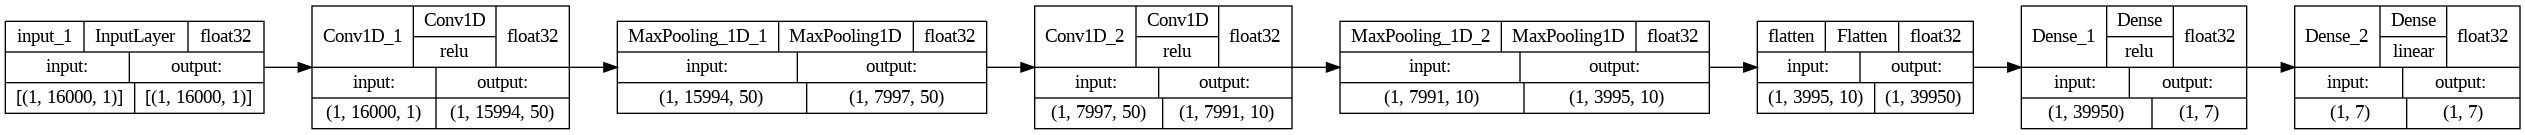

In [18]:
pngFilePath = '/content/gdrive/MyDrive/Colab Notebooks/Music Information Retrieval/Assignment/Final/mid-sized_model_plot.png'
tf.keras.utils.plot_model(model, to_file = pngFilePath, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir = 'LR', dpi = 96, show_layer_activations = True)

In [ ]:
start = time.monotonic()
history = model.fit(train_ds, epochs = 20, batch_size = batch_size, validation_data = validation_ds)
stop = time.monotonic()
print(f'Finished training. It took {stop - start} seconds')

Epoch 1/20
6562/6562 [==============================] - 61s 6ms/step - loss: 0.0155 - mean_absolute_error: 0.1084 - mean_squared_error: 0.0267 - val_loss: 0.0143 - val_mean_absolute_error: 0.1003 - val_mean_squared_error: 0.0175
Epoch 2/20
6562/6562 [==============================] - 48s 6ms/step - loss: 0.0118 - mean_absolute_error: 0.0825 - mean_squared_error: 0.0128 - val_loss: 0.0107 - val_mean_absolute_error: 0.0746 - val_mean_squared_error: 0.0109
Epoch 3/20
6562/6562 [==============================] - 49s 6ms/step - loss: 0.0128 - mean_absolute_error: 0.0898 - mean_squared_error: 0.0154 - val_loss: 0.0222 - val_mean_absolute_error: 0.1557 - val_mean_squared_error: 0.0386
Epoch 4/20
6562/6562 [==============================] - 48s 6ms/step - loss: 0.0222 - mean_absolute_error: 0.1555 - mean_squared_error: 0.0389 - val_loss: 0.0224 - val_mean_absolute_error: 0.1568 - val_mean_squared_error: 0.0404
Epoch 5/20
6562/6562 [==============================] - 48s 6ms/step - loss: 0.0224 

In [ ]:
model.metrics_names

['loss', 'mean_absolute_error', 'mean_squared_error']

In [ ]:
testLoss, mae, mean_squared_error = model.evaluate(test_ds, batch_size = batch_size)

2050/2050 [==============================] - 13s 3ms/step - loss: 0.0227 - mean_absolute_error: 0.1588 - mean_squared_error: 0.0399


In [ ]:
print(type(testLoss))

print(model.metrics_names)
print(testLoss)
print(mae)
print(mean_squared_error)

<class 'float'>
['loss', 'mean_absolute_error', 'mean_squared_error']
0.022679435089230537
0.15875586867332458
0.039912961423397064


Test loss; 0.022679435089230537


'\nOverfitting if: training loss << validation loss\nUnderfitting if: training loss >> validation loss\nJust right if training loss ~ validation loss\n'

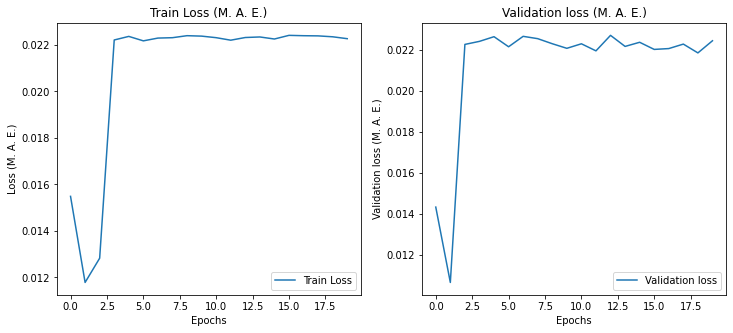

In [ ]:
# https://keras.io/guides/training_with_built_in_methods/

import matplotlib.pyplot as plt

def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss (M. A. E.)");
    plt.title("Train Loss (M. A. E.)");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(val_loss)), val_loss, label="Validation loss");
    plt.xlabel("Epochs"); plt.ylabel("Validation loss (M. A. E.)");
    plt.title("Validation loss (M. A. E.)");
    plt.legend(loc="best");

plot_loss_and_acc(history)
print(f'Test loss; {testLoss}')

'''
Overfitting if: training loss << validation loss
Underfitting if: training loss >> validation loss
Just right if training loss ~ validation loss
'''